## Example 1: Degenerate Markov Chain

#### Overview

We explore a case where **different parameterizations lead to the same stochastic dynamics**. Both systems are **conservative**:

$$X_1 + X_2 = \text{constant}$$

For a total count of 2, the systems produce **identical stochastic transitions**.

---

### System 1: Simple Reversible
$$
X_1 \xrightarrow{k_1 = 1} X_2, \quad X_2 \xrightarrow{k_2 = 1} X_1
$$

The reaction propensities are as follows:
$$
a_1(X_1, X_2) = k_1 \cdot X_1 = X_1, \quad a_2(X_1, X_2) = k_2 \cdot X_2 = X_2
$$

---

### System 2: Bimolecular Intermediate

$$
2 X_1 \xrightarrow{\lambda_1 = 2} X_1 + X_2, \quad 
X_1 + X_2 \xrightarrow{\lambda_2 = 1} 2 X_1, \quad 
X_1 + X_2 \xrightarrow{\lambda_3 = 1} 2 X_2, \quad 
2 X_2 \xrightarrow{\lambda_4 = 2} X_1 + X_2
$$

The reaction propensities are as follows:
$$
a_1(X_1) =   \frac{\lambda_1 X_1 (X_1 - 1)}{2} = X_1 (X_1-1), \quad 
a_2(X_1, X_2) = \lambda_2 \cdot X_1 X_2 = X_1 (X_2), \quad 
a_3(X_1, X_2) = \lambda_3 \cdot X_1 X_2 = X_1 (X_2), \quad 
a_4(X_2) = \frac{\lambda_4  X_2 (X_2 - 1)}{2} = X_2 (X_2-1)
$$

---

### Allowed States and Transitions (Total = 2)

| Current State $(X_1, X_2)$ | Stochiometric Change $(\Delta X_1, \Delta X_2)$| System 1 Propensity | System 2 Propensity |
|-------------------------------|----------------------------------------------------|-------------------|-------------------|
| (2,0)                         | (-1,1)      | $k_1 \cdot 2 = 2$ | $\lambda_1 \cdot \frac{2 \cdot (2-1)}{2} = 2$ |
| (1,1)                         | (-1,1)      | $k_1 \cdot 1 = 1$ | $\lambda_3 \cdot 1 \cdot 1 = 1$ |
| (1,1)                         | (1,-1)      | $k_2 \cdot 1 = 1$ | $\lambda_2 \cdot 1 \cdot 1 = 1$ |
| (0,2)                         | (1,-1)      | $k_2 \cdot 2 = 2$ | $\lambda_4 \cdot \frac{2 \cdot (2-1)}{2} = 2$|

---

✅ **Observation:** Both systems produce **the same stochastic transitions and propensities** for all states with total population 2, despite having **different reaction structures and rate constants**. This illustrates the **degeneracy / non-identifiability** in this Markov system.


In [1]:
import sys
import os

# Add repo root to Python path (one level up from examples/)
sys.path.append(os.path.abspath(".."))  

from src.parsing import *
from src.inference import *
from src.mcmc import *
from CRN_Simulation.CRN import CRN

import numpy as np
import random
import matplotlib.pyplot as plt

In [2]:
# Determine Stochiometric, Reactant and names of reactions
species_names = ["X1", "X2"]

# Define complexes (example: bi-molecular)
complexes = np.array([[0, 0, 0, 1, 1, 2],
                      [0, 1, 2, 0, 1, 0]])

# Create Reactant, Product, Stochiometric Matrix, Define Compatible Reactions and Everything Needed for CRN
reactant_matrix, product_matrix, stoichiometric_matrix, reaction_names, parameter_names, compatible_reactions = generate_reactions(complexes, species_names)

# Plot some output to the screen
print(f"Total reactions generated: {len(reaction_names)}")
max_show = 3
print("Some Reaction Names:", reaction_names[:max_show])

print("Some Non-Unique Stoichiometric Changes")
count_shown = 0
for deltaX, rxn_indices in compatible_reactions.items():
    if len(rxn_indices) > 1:
        deltaX_clean = tuple(int(x) for x in deltaX)
        # Grab all reaction names
        rxn_names = [reaction_names[i] for i in rxn_indices]
        print(f"ΔX = {deltaX_clean} → indices: {rxn_indices}, reactions: {rxn_names}")
        count_shown += 1
        if count_shown >= max_show:
            break

Total reactions generated: 30
Some Reaction Names: ['Empty_to_X2:', 'Empty_to_2X2:', 'Empty_to_X1:']
Some Non-Unique Stoichiometric Changes
ΔX = (0, 1) → indices: [0, 6, 18], reactions: ['Empty_to_X2:', 'X2_to_2X2:', 'X1_to_X1+X2:']
ΔX = (1, 0) → indices: [2, 8, 19], reactions: ['Empty_to_X1:', 'X2_to_X1+X2:', 'X1_to_2X1:']
ΔX = (0, -1) → indices: [5, 11, 23], reactions: ['X2_to_Empty:', '2X2_to_X2:', 'X1+X2_to_X1:']


In [3]:
# Set up Reaction System 1 
reactions_sys1 = ["X1_to_X2", "X2_to_X1"] # X1->X2; X2->X1
rates_sys1     = [1, 1]                   # X1->X2; X2->X1

# Set up Reaction System 2 
reactions_sys2 = ["2X1_to_X1+X2", "X1+X2_to_2X1","X1+X2_to_2X2","2X2_to_X1+X2"] # 2X1->X1+X2; X1+X2->2X1; X1+X2->2X2; 2X2->X1+X2
rates_sys2     = [2, 1, 1, 2] # 2X1->X1+X2; X1+X2->2X1; X1+X2->2X2; 2X2->X1+X2 

In [4]:
# Generate CRN System 1
verbose = True

if verbose:
    print("Creating CRN 1:")

(CRN1_stoichiometric_matrix,
 CRN1_reaction_names,
 CRN1_parameter_names,
 CRN1_propensities,
 trueTheta1,
 CRN1_parameter_values,
 CRN1_indices) = build_CRN_byNameSelection(
    reactant_matrix,
    product_matrix,
    stoichiometric_matrix,
    reaction_names,
    parameter_names,
    species_names,
    selected_names=reactions_sys1,
    rates=rates_sys1,
    verbose=verbose
)

rn1 = CRN(
    species_names=species_names,
    stoichiometric_matrix=CRN1_stoichiometric_matrix,
    parameters_names=CRN1_parameter_names,
    reaction_names=CRN1_reaction_names,
    propensities=CRN1_propensities
)

if verbose:
    print("-" * 20)  

# Generate CRN System 2
if verbose:
    print("Creating CRN2")

(CRN2_stoichiometric_matrix,
 CRN2_reaction_names,
 CRN2_parameter_names,
 CRN2_propensities,
 trueTheta2,
 CRN2_parameter_values,
 CRN2_indices) = build_CRN_byNameSelection(
    reactant_matrix,
    product_matrix,
    stoichiometric_matrix,
    reaction_names,
    parameter_names,
    species_names,
    selected_names=reactions_sys2,
    rates=rates_sys2,
    verbose=verbose
)

rn2 = CRN(
    species_names=species_names,
    stoichiometric_matrix=CRN2_stoichiometric_matrix,
    parameters_names=CRN2_parameter_names,
    reaction_names=CRN2_reaction_names,
    propensities=CRN2_propensities
)

if verbose:
    print("-" * 20) 

Creating CRN 1:

Selected CRN Reactions:
Index  Parameter Reaction Name                  Value     
------------------------------------------------------------
16     k16      X1_to_X2:                      1.0000    
7      k7       X2_to_X1:                      1.0000    

Full trueTheta vector: [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0.]

--------------------
Creating CRN2

Selected CRN Reactions:
Index  Parameter Reaction Name                  Value     
------------------------------------------------------------
29     k29      2X1_to_X1+X2:                  2.0000    
24     k24      X1+X2_to_2X1:                  1.0000    
22     k22      X1+X2_to_2X2:                  1.0000    
13     k13      2X2_to_X1+X2:                  2.0000    

Full trueTheta vector: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 2. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.
 1. 0. 0. 0. 0. 2.]

--------------------


Initial state: {'X1': 1, 'X2': 1}
Trajectory saved to ../data/example1_crn1_trajectory.json
CRN1 trajectory saved to ../data/example1_crn1_trajectory.json
Initial state: {'X1': 1, 'X2': 1}
Trajectory saved to ../data/example2_crn2_trajectory.json
CRN2 trajectory saved to ../data/example2_crn2_trajectory.json


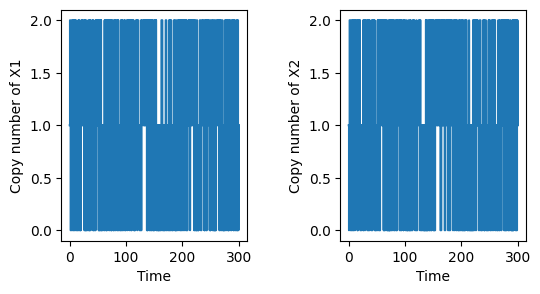

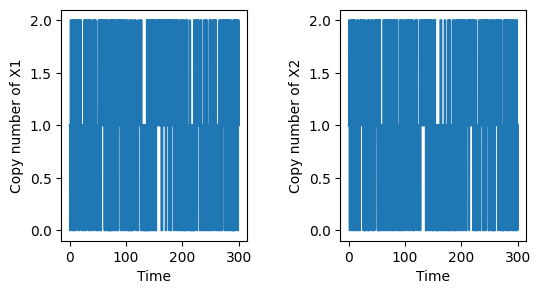

In [5]:
data_dir = "../data"  # relative to examples/ folder
os.makedirs(data_dir, exist_ok=True)

# Generate trajectory for CRN1
time_list1, state_list1 = generate_single_trajectory(
    rn1,
    CRN1_parameter_values,
    species_names,
    finalTime=300,   # adjust as needed
    minVal=1,
    maxVal=1,
    seed=42          # for reproducibility
)

trajectory_file1 = os.path.join(data_dir, "example1_crn1_trajectory.json")
save_trajectory(time_list1, state_list1, filename=trajectory_file1)
print(f"CRN1 trajectory saved to {trajectory_file1}")

# Generate trajectory for CRN2
time_list2, state_list2 = generate_single_trajectory(
    rn2,
    CRN2_parameter_values,
    species_names,
    finalTime=300,   # adjust as needed
    minVal=1,
    maxVal=1,
    seed=42          # reproducibility
)

trajectory_file2 = os.path.join(data_dir, "example2_crn2_trajectory.json")
save_trajectory(time_list2, state_list2, filename=trajectory_file2)
print(f"CRN2 trajectory saved to {trajectory_file2}")

In [6]:
# Parse trajectories for CRN1
print("Parsing trajectory for CRN1")
unique_changes1, unique_states1, jump_counts1, waiting_times1, propensities1 = parse_trajectory(
    state_list1,time_list1,reactant_matrix,compatible_reactions,verbose=True)
print("---------")

# Parse trajectories for CRN2
print("Parsing trajectory for CRN2")
unique_changes2, unique_states2, jump_counts2, waiting_times2, propensities2 = parse_trajectory(
    state_list2, time_list2, reactant_matrix, compatible_reactions, verbose=True)
print("---------")

# Print basic summary
print("Finished parsing trajectories. Summary:")
print(f"CRN1: {len(unique_states1)} unique states observed")
print(f"CRN2: {len(unique_states2)} unique states observed")

Parsing trajectory for CRN1
Tracking 18 unique stoichiometric changes (single trajectory).
Trajectory length: 552 timepoints.  Will iterate to len-2 to avoid final non-jump.
Finished parsing single trajectory. Observed 3 unique states.
---------
Parsing trajectory for CRN2
Tracking 18 unique stoichiometric changes (single trajectory).
Trajectory length: 552 timepoints.  Will iterate to len-2 to avoid final non-jump.
Finished parsing single trajectory. Observed 3 unique states.
---------
Finished parsing trajectories. Summary:
CRN1: 3 unique states observed
CRN2: 3 unique states observed


Extracting local data for stoichiometric change [1, -1] at index 6
✅ All states processed successfully — no empty propensities, consistent lengths, no negative counts, all waiting times valid.
Local data extraction complete. 3 states processed.
Total observed jumps for this local stoichiometric change: 275
Local True Theta = [1. 0. 0.]
Log-Likelihood at True Theta = -136.02281916274433
Maximum Log-Likelihood = -131.93926697939153
Best Multiplier = 1.193877551020408
Best Theta = [1.19387755 0.         0.        ]


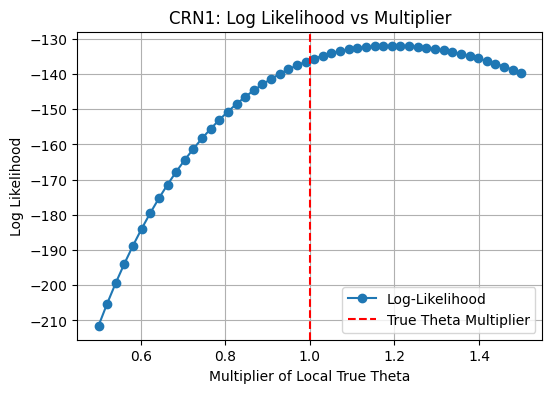

In [7]:
# Local Likelihood Exploration for CRN1

pos_indices, pos_deltaX = get_positive_deltaX_indices_and_values(jump_counts1, unique_changes1)

indexToCheck = pos_indices[0]
deltaXToCheck = pos_deltaX[0]

#Extract the local data for the desired stochiometric change.
(local_counts1, local_waiting_times1, local_propensities1, selected_deltaX) = extract_local_data(
    jump_counts1, waiting_times1, propensities1, unique_changes1, 
    index=indexToCheck, deltaX=deltaXToCheck, verbose=True)

#Extract the Local True Theta for the unique stochiometric change
localTheta1 = trueTheta1[compatible_reactions[selected_deltaX]]

multipliers, ll_values, max_ll, best_multiplier, best_theta = plot_likelihood_vs_theta_multiplier(
    local_counts1,
    local_waiting_times1,
    local_propensities1,
    localTheta1,
    delta=0.5,
    num_points=50,
    title='CRN1: Log Likelihood vs Multiplier'
)

Extracting local data for stoichiometric change [-1, 1] at index 12
✅ All states processed successfully — no empty propensities, consistent lengths, no negative counts, all waiting times valid.
Local data extraction complete. 3 states processed.
Total observed jumps for this local stoichiometric change: 275
Local True Theta = [0. 1. 2.]
Log-Likelihood at True Theta = -136.02281916274433
Maximum Log-Likelihood = -131.93926697939153
Best Multiplier = 1.193877551020408
Best Theta = [0.         1.19387755 2.3877551 ]


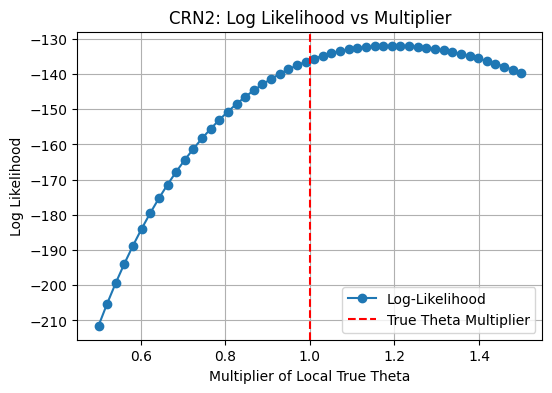

In [8]:
# Local Likelihood Exploration for CRN2

pos_indices, pos_deltaX = get_positive_deltaX_indices_and_values(jump_counts2, unique_changes2)

indexToCheck = pos_indices[1]
deltaXToCheck = pos_deltaX[1]

#Extract the local data for the desired stochiometric change.
(local_counts2, local_waiting_times2, local_propensities2, selected_deltaX) = extract_local_data(
    jump_counts2, waiting_times2, propensities2, unique_changes2, 
    index=indexToCheck, deltaX=deltaXToCheck, verbose=True)

#Extract the Local True Theta for the unique stochiometric change
localTheta2 = trueTheta2[compatible_reactions[selected_deltaX]]

multipliers, ll_values, max_ll, best_multiplier, best_theta = plot_likelihood_vs_theta_multiplier(
    local_counts2,
    local_waiting_times2,
    local_propensities2,
    localTheta2,
    delta=0.5,
    num_points=50,
    title='CRN2: Log Likelihood vs Multiplier'
)

In [ ]:
# Ensure the results directory exists
results_dir = "../results/example1/CRN1"
os.makedirs(results_dir, exist_ok=True)

## Debugging Parameters
runOnlyHigherDim        = False   # Only try to run cases that have >=2 variables
runOnlyOneHigherDimCase = False  # Only run one case with >=2 variables for debugging

## MCMC parameters
NIterates = 500_000
Burnin    = 50_000
Thinout   = 100

jump_counts    = jump_counts1
waiting_times  = waiting_times1
propensities   = propensities1
unique_changes = unique_changes1
trueTheta      = trueTheta1

# Loop over all unique stoichiometric changes
for index, deltaX in enumerate(unique_changes):
    
    print(f"\nProcessing Index: {index}, Stoichiometric Change: {deltaX}")

    # Extract local data for this stoichiometric change
    (local_counts, local_waiting_times, local_propensities, selected_deltaX) = extract_local_data(
        jump_counts, waiting_times, propensities, unique_changes, 
        index=index, deltaX=deltaX, verbose=True
    )

    # Extract local true theta
    localTheta = trueTheta[compatible_reactions[selected_deltaX]]
    num_reactions = len(localTheta)

    # Skip low-dimensional cases if debugging
    if num_reactions < 2 and runOnlyHigherDim:
        print(f"🚫 Index {index} skipped: only {num_reactions} reaction(s) — needs at least 2 to run MCMC.")
        continue

    # Compute 2-norm
    norm_theta = np.linalg.norm(localTheta, ord=2)
    print(f"Local True Theta: {localTheta} (Norm: {norm_theta:.4f})")

    # Compute likelihood for true theta
    likeTrue = local_log_likelihood(local_counts, local_waiting_times, local_propensities, localTheta)
    print(f"True Likelihood = {likeTrue}")

    total_count = sum(local_counts.values())
    print(f"Total Count = {total_count}")

    # Initialize theta for MCMC
    a, b = 0.001, 2.0
    theta_init = np.random.uniform(a, b, size=localTheta.shape)
    likeInit = local_log_likelihood(local_counts, local_waiting_times, local_propensities, theta_init)

    # Run adaptive MCMC only if norm is significant
    if norm_theta > 0.01:
        print(f"Running Adaptive MCMC with spike-and-slab prior...")
        
        filtered_reactions = [reaction_names[i] for i in compatible_reactions[selected_deltaX]]
        print(f"Reaction Names = {filtered_reactions}")

        AdaptiveThetaChain = adaptive_mcmc_spike_slab(
            local_counts, local_waiting_times, local_propensities,
            theta_init, trueTheta, num_iterations=NIterates,
            alpha=2, beta=0.25, pi=0.75, burn_in=Burnin, adapt_every_n=10
        )

        # Define filenames
        filenameKDE = os.path.join(results_dir, f"AdaptiveMCMC_plot_Index_{index}_TotalCount_{total_count}_kde.png")
        filenameChain = os.path.join(results_dir, f"AdaptiveMCMC_plot_Index_{index}_TotalCount_{total_count}_chain.png")
        filenamePosterior = os.path.join(results_dir, f"AdaptiveMCMC_plot_Index_{index}_TotalCount_{total_count}_posterior.png")

        # Plotting
        plot_mcmc_samples(AdaptiveThetaChain, localTheta, epsilon=1e-5, burnin=Burnin, thinout=Thinout, filename=filenameKDE)
        plot_mcmc_chain(AdaptiveThetaChain, filename=filenameChain)
        if num_reactions >= 2:
            calc_network_posteriors(AdaptiveThetaChain, epsilon=1e-5, prob_cutoff=0.05, burnin=Burnin, thinout=Thinout)
            plot_network_and_parameter_posteriors(AdaptiveThetaChain, localTheta, epsilon=1e-5,
                                                 prob_cutoff=0.05, burnin=Burnin, thinout=Thinout, filename=filenamePosterior)

        # Summary statistics to Excel
        chains = [AdaptiveThetaChain]
        labels = ["Adaptive Spike & Slab"]
        summarize_chains(chains, localTheta, labels,
                         results_dir=results_dir, filename="mcmc_summary.xlsx",
                         burnin=Burnin, thinout=Thinout, alpha_ci=0.05, epsilon=1e-3,
                         run_index=index, count=total_count)

        print(f"MCMC completed for index {index}.")

        if (num_reactions > 1) and runOnlyOneHigherDimCase:
            break

    else:
        print(f"Skipping MCMC for index {index}: norm too small ({norm_theta:.4f}).")

    print("**********")



Processing Index: 0, Stoichiometric Change: (0, 1)
Extracting local data for stoichiometric change [0, 1] at index 0
✅ All states processed successfully — no empty propensities, consistent lengths, no negative counts, all waiting times valid.
Local data extraction complete. 3 states processed.
Local True Theta: [0. 0. 0.] (Norm: 0.0000)
True Likelihood = 0.0
Total Count = 0
Skipping MCMC for index 0: norm too small (0.0000).
**********

Processing Index: 1, Stoichiometric Change: (0, 2)
Extracting local data for stoichiometric change [0, 2] at index 1
✅ All states processed successfully — no empty propensities, consistent lengths, no negative counts, all waiting times valid.
Local data extraction complete. 3 states processed.
Local True Theta: [0.] (Norm: 0.0000)
True Likelihood = 0.0
Total Count = 0
Skipping MCMC for index 1: norm too small (0.0000).
**********

Processing Index: 2, Stoichiometric Change: (1, 0)
Extracting local data for stoichiometric change [1, 0] at index 2
✅ All 